In [ ]:
#importing tensorflow_datasets, tensorflow and numpy
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

#load mnist dataset (splitted into train and test set)
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)
--------------

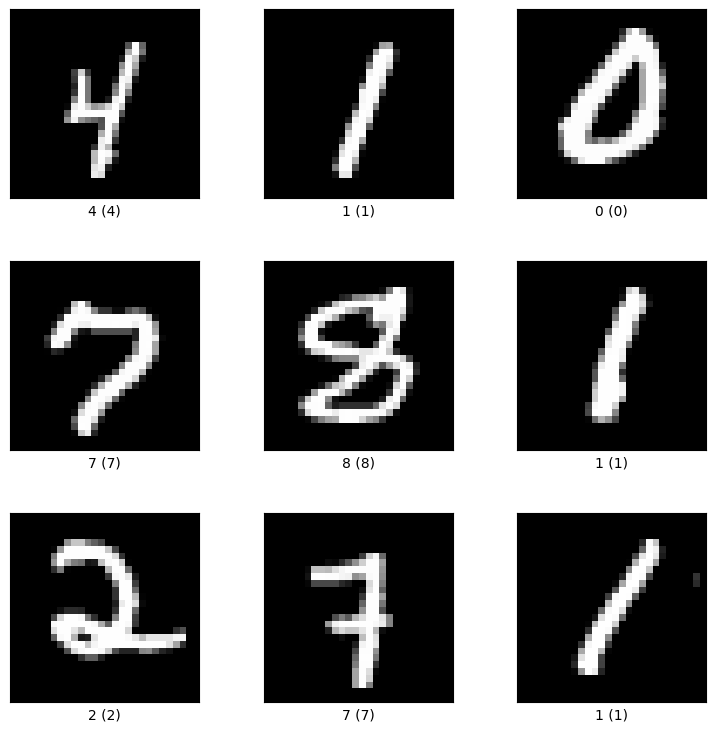

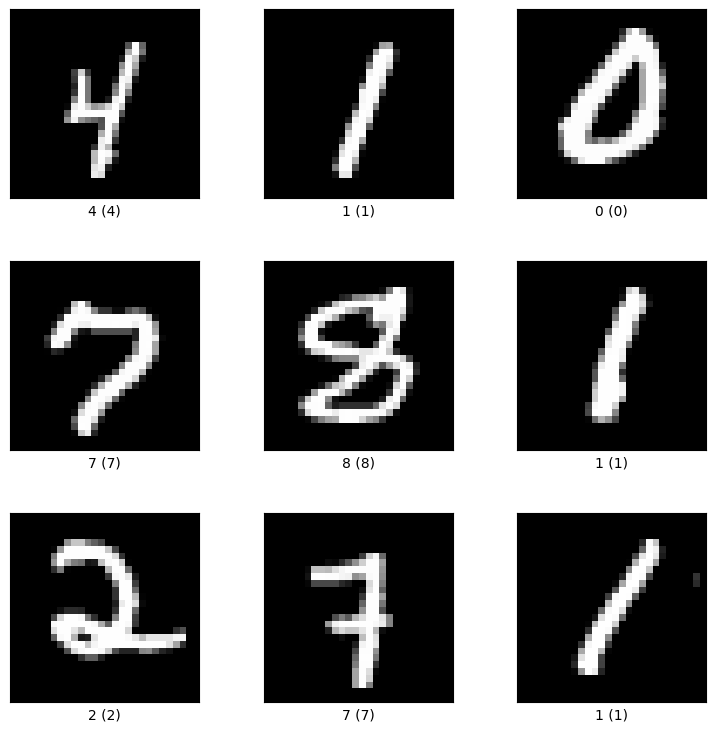

In [ ]:
#print dataset-info
print(ds_info)
print("--------------------")
#display some examples of the dataset
tfds.show_examples(train_ds, ds_info)

In [ ]:
#data pipeline
def data_processing(ds, batchsize=32):
  #extract image and label from ds
  ds = ds.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
  #flatten 28x28 image
  ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  #cast image to float32, normalize to [-1, 1]
  ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  #one-hot-encode labels
  ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  #set shuffle and batch-size
  ds = ds.shuffle(1024).batch(batchsize)
  #set prefetch
  ds = ds.prefetch(4)
  return ds

In [ ]:
#MLP-Model using tf.keras.Model
class MLP(tf.keras.Model):
  def __init__(self, layer_sizes, output_size=10):
    #inherit from tf.keras.Model
    super().__init__()
    self.mlp_layers = []

    #creating layers
    for layer_size in layer_sizes:
      #create layer using Dense() and sigmoid
      layer = tf.keras.layers.Dense(units=layer_size, activation='sigmoid')
      self.mlp_layers.append(layer)
    #create output layer with softmax
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')

  #call function
  def call(self, x):
    #pass x through the layers (and their call functions)
    for layer in self.mlp_layers:
      x = layer(x)
    #pass activation through output_layer and then return the result
    y = self.output_layer(x)
    return y

  #function to calculate the accuracy
  def calculate_accuracy(self, y_true, y_pred):
    predicted_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    correct_predictions = tf.equal(predicted_labels, true_labels)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

  #train function
  def fit(self, train_ds, test_ds, n_epochs, loss_fn, optimizer):
    total_train_losses = []
    total_train_accuracies = []
    total_test_losses = []
    total_test_accuracies = []

    #for each epoch
    for epoch in range(n_epochs):
      train_losses = []
      train_accuracies = []

      #for each batch of data of TRAIN set
      for x, target in train_ds:
        #using context-manager of GradientTape
        with tf.GradientTape() as tape:
          pred = self.call(x)
          loss = loss_fn(target, pred)

        #get gradients, apply gradients to optimizer
        gradients = tape.gradient(loss, self.variables)
        optimizer.apply_gradients(zip(gradients, self.variables))
        train_losses.append(loss.numpy())

        train_accuracy = self.calculate_accuracy(target, pred)
        train_accuracies.append(train_accuracy.numpy())

      #calculate mean of train_losses and train_accuracies
      epoch_train_loss = np.mean(train_losses)
      epoch_train_accuracy = np.mean(train_accuracies)

      total_train_losses.append(epoch_train_loss)
      total_train_accuracies.append(epoch_train_accuracy)

      print(f"Epoch {epoch+1}/{n_epochs}: TRAIN Loss : {epoch_train_loss}, TRAIN Accuracy : {epoch_train_accuracy}")

      test_losses = []
      test_accuracies = []

      #for each batch of data of TEST set
      for x, target in test_ds:
        pred = self.call(x)
        loss = loss_fn(target, pred)
        test_accuracy = self.calculate_accuracy(target, pred)

        test_losses.append(loss.numpy())
        test_accuracies.append(test_accuracy.numpy())

      epoch_test_loss = np.mean(test_losses)
      epoch_test_accuracy = np.mean(test_accuracies)

      total_test_losses.append(epoch_test_loss)
      total_test_accuracies.append(epoch_test_accuracy)

      print(f"Epoch {epoch+1}/{n_epochs}: TEST Loss : {epoch_test_loss}, TEST Accuracy : {epoch_test_accuracy}")

    return total_train_losses, total_train_accuracies, total_test_losses, total_test_accuracies


In [ ]:
#visualization function from pdf
import matplotlib.pyplot as plt
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
  """Visualizes accuracy and loss for training and test data using the mean of each epoch.
      Loss is displayed in a regular line, accuracy in a dotted line.
      Training data is displayed in blue, test data in red.
  Parameters
  -----------
  train_losses : numpy.ndarray
    training losses
  train_accuracies : numpy.ndarray
    training accuracies
  test_losses : numpy.ndarray
    test losses
  test_accuracies : numpy.ndarray
    test accuracies
  """
  plt.figure()
  line1, = plt.plot(train_losses, "b-")
  line2, = plt.plot(test_losses, "r-")
  line3, = plt.plot(train_accuracies, "b:")
  line4, = plt.plot(test_accuracies, "r:")
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
  plt.show

In [ ]:
#main
#load data
train = tfds.load('mnist', split='train')
test = tfds.load('mnist', split='test')

#initial setting
layer_size = [256, 256]
epochs = 10
learning_rate = 0.1

#loss function: CCE, optimizer: stochastic gradient descent with learning_rate as learning rate
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

model = MLP(layer_size)
train_ds = data_processing(train, 32)
test_ds = data_processing(test, 32)

#train_loss, train_accuracy, test_loss, test_accuracy = model.fit(train_ds, test_ds, epochs, loss_fn, optimizer)
results = model.fit(train_ds, test_ds, epochs, loss_fn, optimizer)

Epoch 1/10: TRAIN Loss : 0.612068235874176, TRAIN Accuracy : 0.8147333264350891
Epoch 1/10: TEST Loss : 0.30651727318763733, TEST Accuracy : 0.9092451930046082
Epoch 2/10: TRAIN Loss : 0.28188666701316833, TRAIN Accuracy : 0.9157166481018066
Epoch 2/10: TEST Loss : 0.225513756275177, TEST Accuracy : 0.9345048069953918
Epoch 3/10: TRAIN Loss : 0.22038821876049042, TRAIN Accuracy : 0.9340166449546814
Epoch 3/10: TEST Loss : 0.19479741156101227, TEST Accuracy : 0.9397963285446167
Epoch 4/10: TRAIN Loss : 0.17689944803714752, TRAIN Accuracy : 0.9479666948318481
Epoch 4/10: TEST Loss : 0.15623991191387177, TEST Accuracy : 0.9532747864723206
Epoch 5/10: TRAIN Loss : 0.14779315888881683, TRAIN Accuracy : 0.9564666748046875
Epoch 5/10: TEST Loss : 0.1409645676612854, TEST Accuracy : 0.9581669569015503
Epoch 6/10: TRAIN Loss : 0.12624326348304749, TRAIN Accuracy : 0.9628999829292297
Epoch 6/10: TEST Loss : 0.11423252522945404, TEST Accuracy : 0.9654552936553955
Epoch 7/10: TRAIN Loss : 0.109851

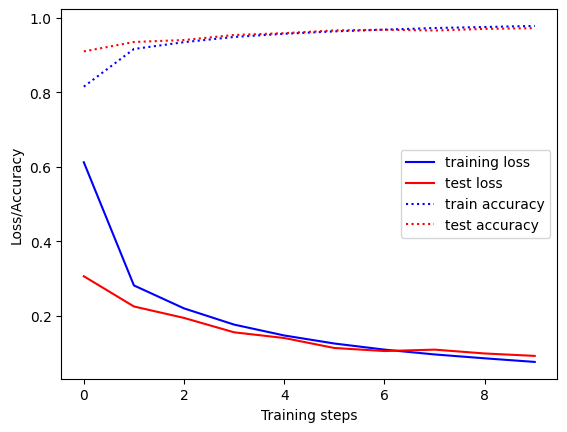

In [ ]:
visualization(*results)
#visualization(train_loss, train_accuracy, test_loss, test_accuracy)

#EXPERIMENTING


In [ ]:
#maybe come up with a better name for this function
#This function is to easily change the parameters, create the model and return the train and test losses and accuracies for further plotting
def model_parameter_testing(loss_fn, optimizer, epochs=10, layer_size=[256, 256], batchsize=32):
  #load data
  train = tfds.load('mnist', split='train')
  test = tfds.load('mnist', split='test')
  train_ds = data_processing(train, batchsize)
  test_ds = data_processing(test, batchsize)

  model = MLP(layer_size)

  return model.fit(train_ds, test_ds, epochs, loss_fn, optimizer)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots(data):
    """Plots subplots in a grid based on the number of tuples provided with equal scales.

    Parameters:
    -----------
    data : list of tuples
        Each tuple contains (train_loss, train_accuracy, test_loss, test_accuracy).
    """
    #get grid-size depending on data
    num_plots = len(data)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))

    max_steps = max([max(len(t[0]), len(t[2])) for t in data])  # Maximum steps among train and test data

    #get values for calculating y-min and y-max, so all of the plots have the same axis-values, for comparability
    all_train_loss = [t[0] for t in data]
    all_test_loss = [t[2] for t in data]
    all_train_accuracy = [t[1] for t in data]
    all_test_accuracy = [t[3] for t in data]

    #calculate y-max
    max_y = max(
        max(max(all_train_loss)), max(max(all_test_loss)),
        max(max(all_train_accuracy)), max(max(all_test_accuracy))
    )

    #calculate y-min
    min_y = min(
        min(min(all_train_loss)), min(min(all_test_loss)),
        min(min(all_train_accuracy)), min(min(all_test_accuracy))
    )

    #plot subplots enumerating over the data
    for i, (train_loss, train_accuracy, test_loss, test_accuracy) in enumerate(data):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        ax.plot(train_loss, label='Train Loss', color='blue')
        ax.plot(test_loss, label='Test Loss', color='red')
        ax.plot(train_accuracy, label='Train Accuracy', linestyle=':', color='blue')
        ax.plot(test_accuracy, label='Test Accuracy', linestyle=':', color='red')
        ax.set_xlabel('Training steps')
        ax.set_ylabel('Loss/Accuracy')
        ax.legend()
        ax.set_title(f'Plot {i+1}')
        ax.set_xlim(0, max_steps)  # Set the same x-axis limit for all subplots
        ax.set_ylim(min_y, max_y)  # Set the same y-axis limit for all subplots

    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axs[row, col])

    plt.tight_layout()
    plt.show()

In [ ]:
data = []

#first deviation, decreasing epochs from 10 to 5
learning_rate = 0.1

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
epochs = 5
layer_size = [256, 256]
batchsize = 32
results1 = model_parameter_testing(loss_fn, optimizer, epochs, layer_size, batchsize)

data.append(results1)


#second deviation, decreasing learningrate from 0.1 to 0.01
learning_rate = 0.01

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
epochs = 10
layer_size = [256, 256]
batchsize = 32
results2 = model_parameter_testing(loss_fn, optimizer, epochs, layer_size, batchsize)

data.append(results2)


#third deviation, decreasing layer_size from [256, 256] to [64, 64]
learning_rate = 0.1

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
epochs = 10
layer_size = [64, 64]
batchsize = 32
results3 = model_parameter_testing(loss_fn, optimizer, epochs, layer_size, batchsize)

data.append(results3)


#forth deviation, increasing batchsize from 32 to 128
learning_rate = 0.1

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
epochs = 10
layer_size = [256, 256]
batchsize = 128
results4 = model_parameter_testing(loss_fn, optimizer, epochs, layer_size, batchsize)

data.append(results4)


Epoch 1/5: TRAIN Loss : 0.6074869632720947, TRAIN Accuracy : 0.8175833225250244
Epoch 1/5: TEST Loss : 0.2987525165081024, TEST Accuracy : 0.9128394722938538
Epoch 2/5: TRAIN Loss : 0.28090280294418335, TRAIN Accuracy : 0.9163500070571899
Epoch 2/5: TEST Loss : 0.23168492317199707, TEST Accuracy : 0.9346046447753906
Epoch 3/5: TRAIN Loss : 0.2185961902141571, TRAIN Accuracy : 0.9358999729156494
Epoch 3/5: TEST Loss : 0.17967219650745392, TEST Accuracy : 0.9476836919784546
Epoch 4/5: TRAIN Loss : 0.17636539041996002, TRAIN Accuracy : 0.9477999806404114
Epoch 4/5: TEST Loss : 0.17445853352546692, TEST Accuracy : 0.9473841786384583
Epoch 5/5: TRAIN Loss : 0.14658504724502563, TRAIN Accuracy : 0.9563833475112915
Epoch 5/5: TEST Loss : 0.15423861145973206, TEST Accuracy : 0.9528753757476807
Epoch 1/10: TRAIN Loss : 1.7861751317977905, TRAIN Accuracy : 0.5443999767303467
Epoch 1/10: TEST Loss : 1.1423277854919434, TEST Accuracy : 0.778654158115387
Epoch 2/10: TRAIN Loss : 0.832374095916748, 

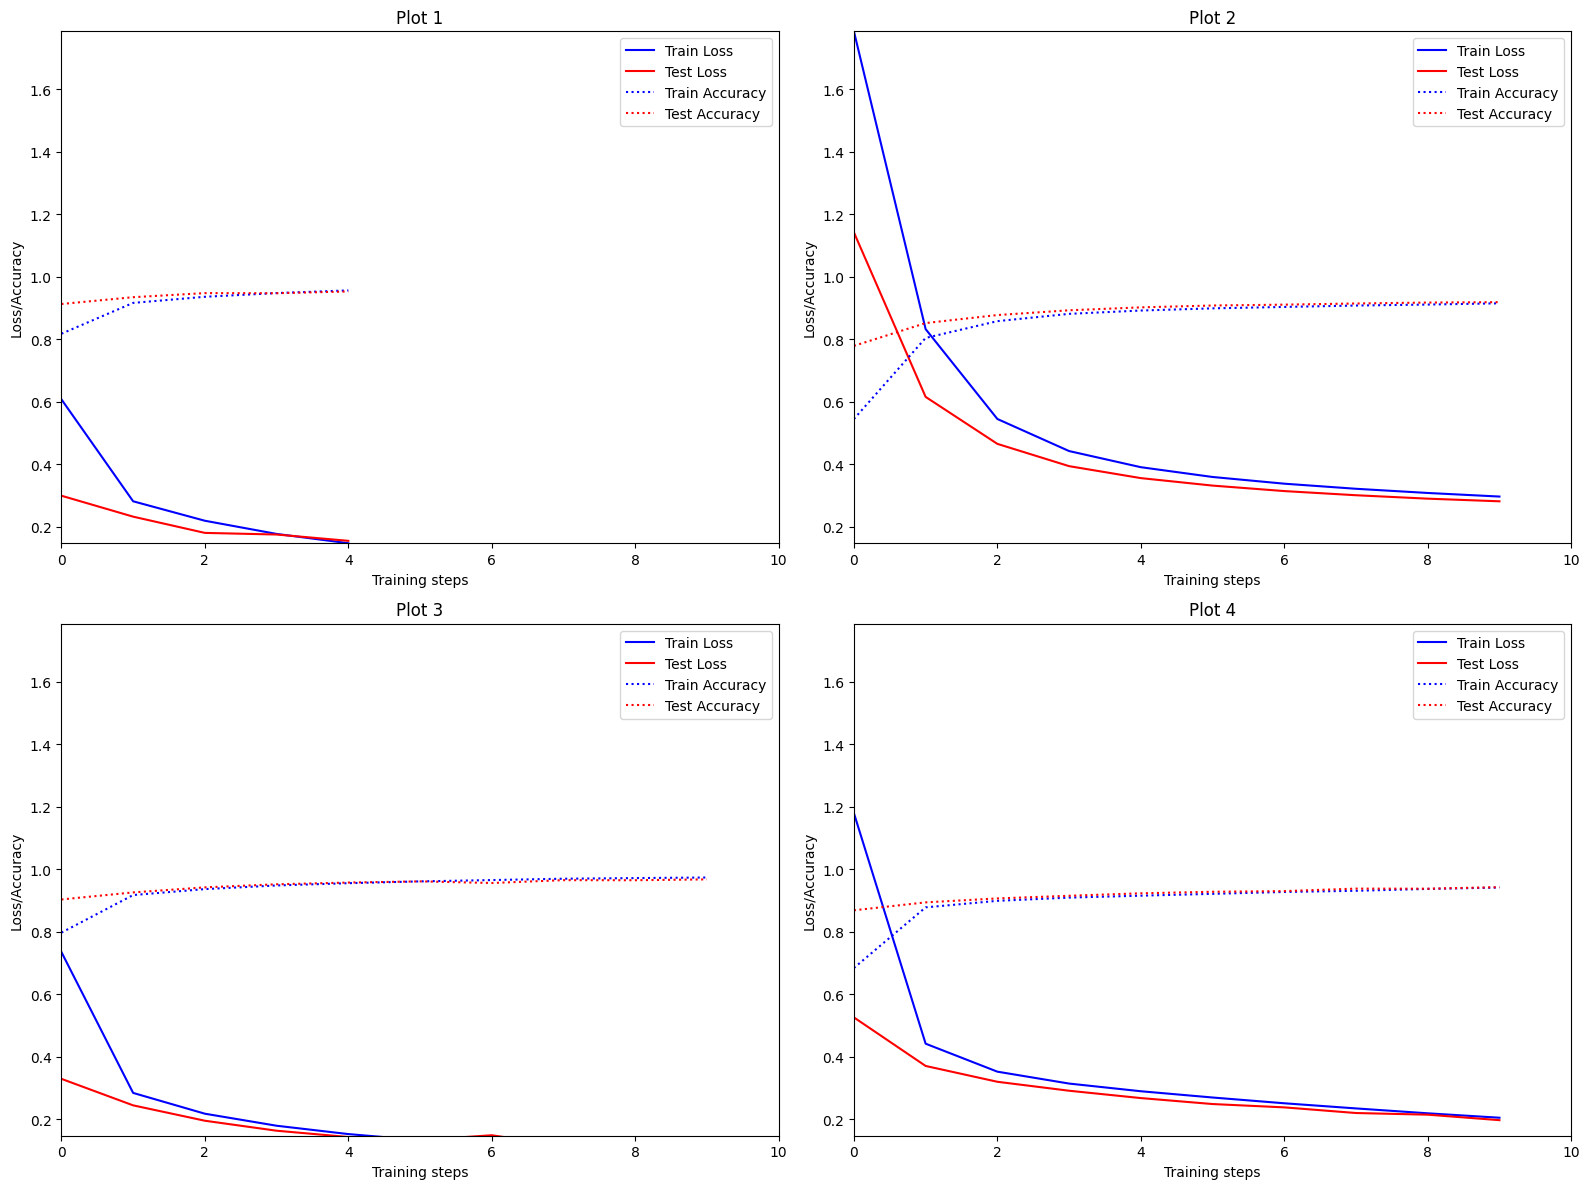

In [ ]:
plot_subplots(data)